## Visualization

In [110]:
import shap
import torch
import joblib
import pandas as pd
from src.model import EITCClassifier

### Load Model

In [111]:
scaler = joblib.load("models/scaler_eitc.joblib")
df = pd.read_parquet("data/synthetic_taxpayer_data.parquet")
features = [
    "filing_status_code",
    "num_dependents",
    "num_children_under_17",
    "wages",
    "agi",
    "investment_income",
    "disability"
]

X_scaled = scaler.transform(df[features])
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

model = EITCClassifier(input_dim=X_scaled.shape[1])
model.load_state_dict(torch.load("models/eitc_classifier.pth"))
model.eval()

EITCClassifier(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

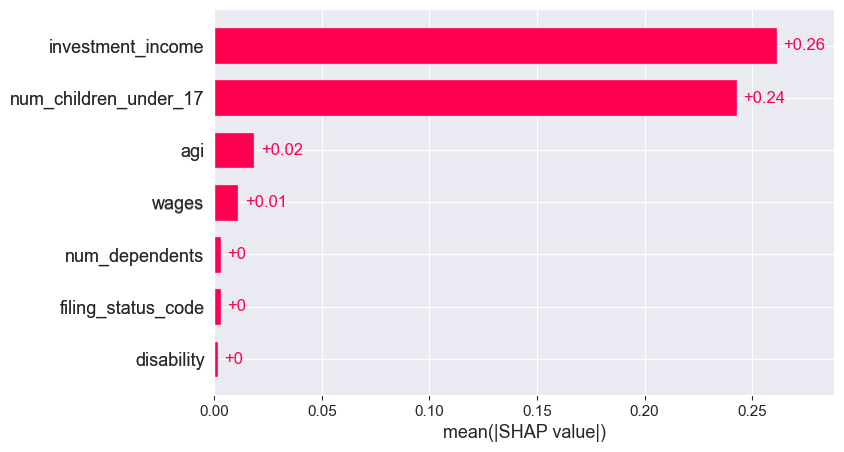

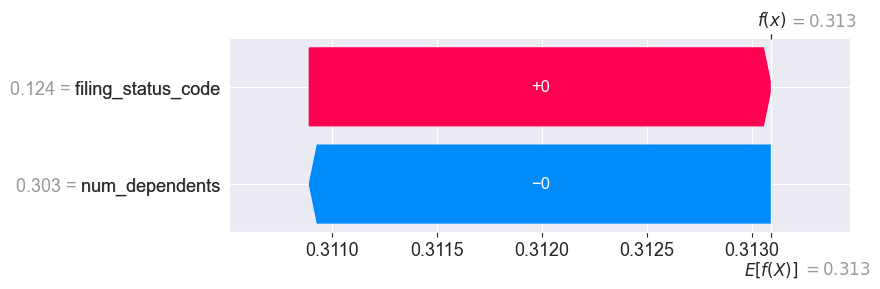

In [112]:
X_df = pd.DataFrame(
    scaler.transform(df[features])[:500],
    columns=features
)

def model_wrapped(x):
    if isinstance(x, pd.DataFrame):
        x = x.values
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1).numpy()
    return probs

masker = shap.maskers.Independent(X_df[:100].values)
explainer = shap.Explainer(model_wrapped, masker)
shap_values = explainer(X_df)

shap.plots.bar(shap_values[..., 1])

row_idx = 0
class_idx = 1

shap_single = shap.Explanation(
    values=shap_values.values[row_idx, class_idx],
    base_values=shap_values.base_values[row_idx, class_idx],
    data=shap_values.data[row_idx],
    feature_names=shap_values.feature_names
)

shap.plots.waterfall(shap_single)